# Supervised Classification for Cricket match outcomes

This project models whether the **team batting second wins** in an ODI match, using performance features from the **first innings** and the **first 10 overs of the second innings**. In this analysis, we focus on the Support Vector Machine (SVM) classifier — a method that finds the optimal separating hyperplane between classes. The emphasis of this analysis is not predictive accuracy, but a deeper understanding of how and why the SVM works, and how its parameters affect its performance. We have done limited feature engineering as a result of this focus, and hence I think a better accuracy could be achieved if more time had been spent on that.

SVM is an interesting method to focus on, as we can compare how the different choices of kernel function can affect performance. First we introduce the SVM from a mathematical viewpoint, then we implement it and compare different kernels, and finally we try to improve the accuracy of the model.





# Mathematical Formulation: Support Vector Machines and Kernel Methods

The following section is based on the sci-kit learn documentation on SVMs [here](https://scikit-learn.org/stable/modules/svm.html#svm-kernels) [1], and the book *Elements of Statistical Learning* by Hastie, Tibshirani and Friedman (2009)[2].

## 1. Primal Optimization Problem

For a binary classification problem with training data $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i \in \mathbb{R}^p$ and $y_i \in \{-1, +1\}$, the goal is to find $\mathbf{w} \in \mathbb{R}^p $ and $b \in \mathbb{R}$ such that the decision function $sign(\mathbf{w}^T \mathbf{x}_i + b)$ is correct for most samples. The soft-margin Support Vector Machine (SVM) seeks a hyperplane that maximizes the margin (perpendicular distance between decision boundary and closest datapoints from each class) while allowing some misclassifications. This is formulated as:

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{s.t.} \quad & y_i(\mathbf{w}^\top \mathbf{x}_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0, \quad i = 1, \dots, n
\end{aligned}
$$

The term $\frac{1}{2}\|\mathbf{w}\|^2$ encourages a large margin, while the penalty term $C\sum_i \xi_i$ penalizes margin violations. The constant $C>0$ controls the trade-off between maximizing the margin and minimizing training errors.

---

## 2. Dual Problem Formulation

Introducing Lagrange multipliers $\alpha_i \ge 0$ and $\mu_i \ge 0$, we construct the Lagrangian:

$$
\mathcal{L}(\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\mu}) =
\frac{1}{2}\|\mathbf{w}\|^2 + C\sum_i \xi_i
- \sum_i \alpha_i [y_i(\mathbf{w}^\top \mathbf{x}_i + b) - 1 + \xi_i]
- \sum_i \mu_i \xi_i
$$

Setting the partial derivatives with respect to the primal variables to zero gives:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = 0 \Rightarrow \mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i, \quad
\frac{\partial \mathcal{L}}{\partial b} = 0 \Rightarrow \sum_i \alpha_i y_i = 0, \quad
\frac{\partial \mathcal{L}}{\partial \xi_i} = 0 \Rightarrow \alpha_i + \mu_i = C
$$

Substituting back yields the **dual optimization problem**:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_i \alpha_i - \frac{1}{2}\sum_i \sum_j \alpha_i \alpha_j y_i y_j (\mathbf{x}_i^\top \mathbf{x}_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \sum_i \alpha_i y_i = 0
\end{aligned}
$$

---

## 3. Kernel Trick and Nonlinear Mapping

The dual form depends only on inner products $\mathbf{x}_i^\top \mathbf{x}_j$. By replacing these with a kernel function

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^\top \phi(\mathbf{x}_j),
$$

we implicitly map the inputs into a higher-dimensional feature space via $\phi(\cdot)$ without explicitly computing the transformation. The dual problem becomes:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_i \alpha_i - \frac{1}{2}\sum_i \sum_j \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \sum_i \alpha_i y_i = 0
\end{aligned}
$$

The resulting decision function is:

$$
f(\mathbf{x}) = \sum_i \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b,
$$

and the final prediction is $\hat{y} = \text{sign}(f(\mathbf{x}))$. Only observations with $\alpha_i > 0$ (the *support vectors*) influence the boundary.

---

## 4. Common Kernel Functions

Different choices of the kernel function $K(\cdot, \cdot)$ allow the SVM to learn complex, non-linear relationships.

| **Kernel** | **Definition** | **Effect** |
|-------------|----------------|-------------|
| Linear | $K(x, x') = x^\top x'$ | Linear separation; equivalent to no feature mapping. |
| Polynomial | $K(x, x') = (\gamma x^\top x' + r)^d$ | Models interactions up to degree $d$. |
| RBF (Gaussian) | $K(x, x') = \exp(-\gamma \|x - x'\|^2)$ | Infinite-dimensional mapping; smooth non-linear boundaries. |
| Sigmoid (Tanh) | $K(x, x') = \tanh(\gamma x^\top x' + r)$ | Similar to neural network activations; non-linear boundaries. |

---

## 5. Mathematical Properties of Kernels

### (a) Linear Kernel
This is the simplest case where $K(x, x') = x^\top x'$.  
The decision boundary is a hyperplane:

$$
f(x) = \mathbf{w}^\top x + b
$$

and the margin width is $\frac{2}{\|\mathbf{w}\|}$.

### (b) Polynomial Kernel
The polynomial kernel,

$$
K(x, x') = (\gamma x^\top x' + r)^d,
$$

expands the feature space to include all cross-terms up to degree $d$.  
For instance, with $d=2$, quadratic interactions between features (e.g., run rate × wickets) are captured.  
Larger $d$ increases model complexity but can cause overfitting.

### (c) Radial Basis Function (RBF) Kernel
Defined as:

$$
K(x, x') = \exp(-\gamma \|x - x'\|^2),
$$

this kernel measures local similarity, producing smooth, non-linear decision boundaries.  
The parameter $\gamma$ controls the influence radius of support vectors:

$$
\text{Small } \gamma \Rightarrow \text{broader, smoother decision boundary}; \quad
\text{Large } \gamma \Rightarrow \text{narrower, more complex boundary.}
$$

### (d) Sigmoid Kernel
Inspired by neural networks:

$$
K(x, x') = \tanh(\gamma x^\top x' + r).
$$

It resembles the activation function of a neuron.  
However, for the kernel to be positive semi-definite (and ensure convexity), parameters must satisfy certain conditions, typically $\gamma > 0$ and $r < 0$.  
While less commonly used, the sigmoid kernel offers an interesting bridge between SVMs and neural network theory.

---

## 6. Comparison to Logistic Regression

In [3], chapter 9 section 9.5 the authors compare SVM hinge loss to logistic regression loss functions. This is worth mentioning here as our full project also considers logistic regression models. 

The SVM minimizes the *hinge loss*:

$$
L(y, f(x)) = \max(0, 1 - y f(x)),
$$

which penalizes only points that lie within or across the margin.  
In contrast, logistic regression minimizes the log-loss:

$$
L(y, f(x)) = \log(1 + e^{-y f(x)}).
$$

Both models regularize $\|\mathbf{w}\|^2$, but SVMs focus on maximizing the margin, leading to sparse solutions (only support vectors matter), while logistic regression considers all points.

---

## 7. Implementation on Cricket ODI Dataset

Now we will implement the Kernel trick for SVM in the context of the Cricket ODI dataset. We will adjust the dataset slightly, so that we have the desired prediction problem of predicting match outcome based on the first innings and first 10 overs of the second innings. To do this we use pandas to manipulate our data, then fit the models using sci-kit learn. Once fitted, we can compare the performance of the different kernels on this dataset using ROC AUC and accuracy metrics.

### 8. Import Libraries and Prepare Data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


file_path = "/Users/elliotmoore/Documents/DST/odi_bbb.csv"

try:
    df = pd.read_csv(
        file_path,
        encoding="utf-8",     # handle common encoding issues
        na_values=["", "NA"], # treat empty strings or "NA" as missing
        dtype=str             # (optional) read all as strings first if unsure
    )
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: Problem parsing the CSV.")



### 9. Feature Engineering

Here we modify the dataset such that we have the first innings and the first 10 overs of the second innings as features using pandas. We also create features such as run rate, wickets lost and boundaries scored using the ball by ball data. Finally we split the data into a training and testing set for model evaluation.

In [2]:

# Make total runs column
df["total_runs"] = df["runs_off_bat"] + df["extras"]

numeric_cols = [
    "ball", "runs_off_bat", "extras", "total_runs"
]

# Ensure all of the numeric features are numeric - some were strings in my testing.
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Get first and second innings
innings1 = df[df["innings"] == '1']
innings2 = df[df["innings"] == '2']

# First innings

# Here I added boundaries as a feature as it was deemed useful in the EDA in Assessment 0
first_innings = innings1.groupby(["match_id", "batting_team"]).agg(
    runs_1=("total_runs", "sum"),
    wickets_1=("wicket_type", "count"),
    boundaries_1=("runs_off_bat", lambda x: ((x == 4) | (x == 6)).sum()),
    balls_faced_1=("ball", "count")  # total deliveries
).reset_index()

first_innings["overs_1"] = first_innings["balls_faced_1"] / 6
first_innings["run_rate_1"] = first_innings["runs_1"] / first_innings["overs_1"]


# Second innings (up to over 10)
innings2_10 = innings2[innings2["ball"] <= 10]

second_innings = innings2_10.groupby(["match_id", "batting_team"]).agg(
    runs_2_10=("total_runs", "sum"),
    wickets_2_10=("wicket_type", "count"),
    boundaries_2_10=("runs_off_bat", lambda x: ((x == 4) | (x == 6)).sum()),
    balls_faced_2_10=("ball", "count")
).reset_index()

second_innings["overs_2_10"] = second_innings["balls_faced_2_10"] / 6
second_innings["run_rate_2_10"] = second_innings["runs_2_10"] / second_innings["overs_2_10"]


# Merge innings
matches = pd.merge(first_innings, second_innings, on="match_id", suffixes=("_1", "_2"))

# Add metadata (winner etc.)
meta_cols = ["match_id", "team1", "team2", "winner", "venue.x", "season"]
meta = df[meta_cols].drop_duplicates("match_id")


# Drop matches where outcome is NA

meta = meta.dropna(subset=['winner'])

matches = matches.merge(meta, on="match_id")

# --- TARGET VARIABLE ---
matches["team2_win"] = (matches["winner"] == matches["team2"]).astype(int)



In [3]:

# Here we one-hot-encode the qualitative varibales.
cat_cols = ["batting_team_1", "batting_team_2", "venue.x", "season"]
matches_encoded = pd.get_dummies(matches, columns=cat_cols, drop_first=True)


X = matches_encoded.drop(columns=["match_id", "winner", "team1", "team2", "team2_win"])
y = matches_encoded["team2_win"]

# Test / Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



My main concern here is that one hot encoding all of the categorical variables makes our feature space very high dimensional, which makes the data sparse. I consider this later when I try to improve the model, however for now we will fit the SVM on this full feature space.

### 10. Model Fitting and Parameter Tuning

Now that the data has been modified and split into a training and testing set, we can train the SVM model and compare which of the kernels work the best. SVM is sensitive to scale of features so we standardize these using StandardScaler() [4]. Since we have a binary classification problem, we will use SVC from sci-kit learn [1] with different kernel options. SVM does handle multi-class problems, but here we focus on binary classification for our match outcome problem. The Sci-kit learn documentation explicitly states that the RBF kernel needs to have its gamma and C parameters tuned for good performance [4], so we use grid search cross-validation to find the best parameters for each kernel. 


 Summary of Kernel Performance:
linear   | AUC: 0.720 | Acc: 0.683 | Params: {'svc__C': 0.1}
poly     | AUC: 0.627 | Acc: 0.621 | Params: {'svc__C': 10, 'svc__degree': 3, 'svc__gamma': 'scale'}
rbf      | AUC: 0.702 | Acc: 0.558 | Params: {'svc__C': 0.1, 'svc__gamma': 'auto'}
sigmoid  | AUC: 0.759 | Acc: 0.594 | Params: {'svc__C': 0.1, 'svc__gamma': 'scale'}


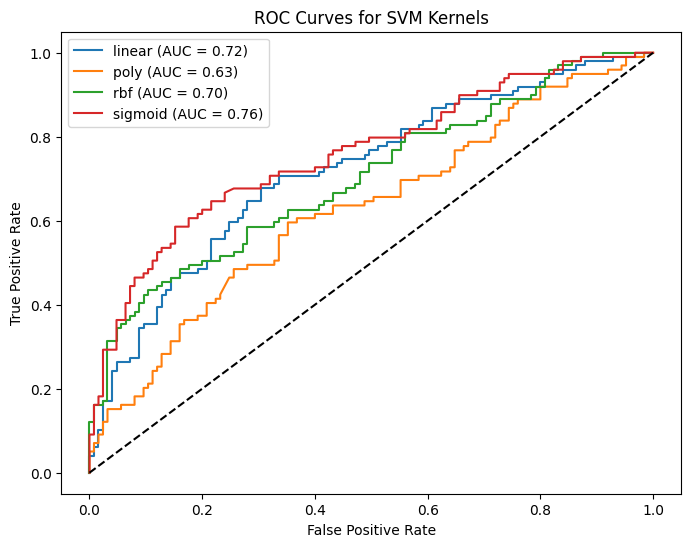

In [ ]:

param_grids = {
    'linear': {'svc__C': [0.1, 1, 10, 100]},
    'poly':   {'svc__C': [0.1, 1, 10], 'svc__degree': [2, 3, 4], 'svc__gamma': ['scale', 'auto']},
    'rbf':    {'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto', 0.1, 0.01]},
    'sigmoid':{'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 'auto']}
}


results = {}

for kernel, params in param_grids.items():
    
    # Create pipeline with scaling + SVM
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, probability=True, random_state=42))
    ])
    
    # Grid search over hyperparameters
    grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Best model
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Store performance
    results[kernel] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'model': best_model
    }


print("\n Summary of Kernel Performance:")
for kernel, res in results.items():
    print(f"{kernel:8} | AUC: {res['auc']:.3f} | Acc: {res['accuracy']:.3f} | Params: {res['best_params']}")

# Plot ROC curve for all kernels
plt.figure(figsize=(8,6))
for kernel, res in results.items():
    model = res['model']
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{kernel} (AUC = {res['auc']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM Kernels')
plt.legend()
plt.show()


### 11. Discussion of Results

From our ROC plot above we can see that the sigmoid kernel performed the best on this dataset, followed by the linear kernel. This implies that the feature space is roughly linearly separable, with some non-linearities that the sigmoid kernel was able to capture. The polynomial and RBF kernels did not perform as well, possibly due to overfitting - they are more flexible models and so might have added unnecessary complexity to the decision boundary. The sigmoid kernel can behave like a linear kernel whilst also capturing non-linear relationships, which seems to suit this dataset well. The results from the parameter tuning also suggest that a lower C value (more regularization) worked better for this dataset, which again suggests that a simpler decision boundary is preferable to avoid overfitting.

### 12. Improving Model Performance

To try and improve the performance of our SVM model, we build an ensemble model based on ideas shown in DST lectures [5] that combines the linear, rbf and sigmoid kernels (since they performed the best individually) using a voting classifier using the documentation [6]. In particular, we use a soft voting classifier that averages the predicted probabilities from each base model to make the final prediction. This allows us to leverage the strengths of both kernels and potentially improve overall accuracy. Whilst I was reading the sci-kit learn documentation, I found a section on feature selection using a function called SelectKBest [7]. This function select the top k features based on univariate statistical tests. I implement this to see if it can help improve the model performance by reducing noise from less relevant features.


In [ ]:

# Keep top 10 most informative features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# See which features were selected
selected_features = X.columns[selector.get_support()]
print("Top features selected:", list(selected_features))


Top features selected: ['runs_1', 'wickets_1', 'boundaries_1', 'balls_faced_1', 'overs_1', 'run_rate_1', 'wickets_2_10', 'boundaries_2_10', 'batting_team_2_India', 'batting_team_2_Papua New Guinea']


Based on this, I am going to try and fit an ensemble model that does drops all features except runs, wickets, boundaries and run rate for both innings. This means we only rely on information obtained during the match itself, rather than pre-match factors such as team strength or venue. I think if the model can perform well with just these features, it shows we have built a robust learner.

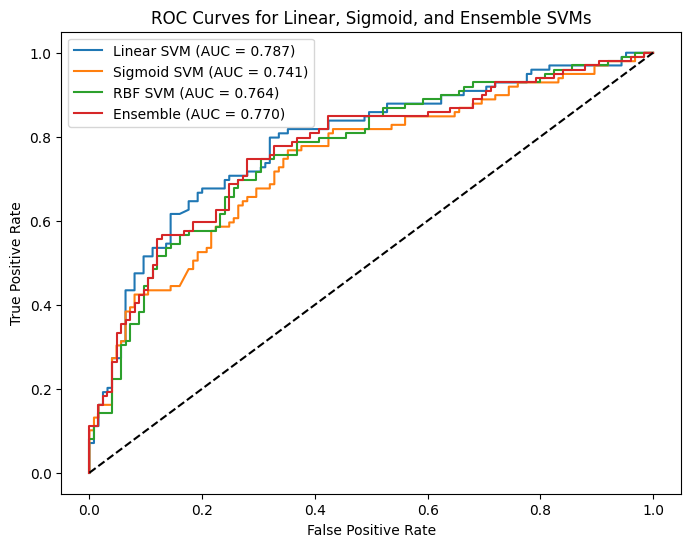

In [ ]:


# Select only core features from above
core_features = [
    "runs_1", "wickets_1", "boundaries_1", "run_rate_1",
    "runs_2_10", "wickets_2_10", "boundaries_2_10", "run_rate_2_10"
]

# Subset the dataset
X_core = matches_encoded[core_features]
y_core = matches_encoded["team2_win"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_core, y_core, test_size=0.2, random_state=42, stratify=y_core
)

# Individual models
linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=0.1, probability=True, random_state=42))
])

sigmoid_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="sigmoid", C=0.1, gamma="auto", probability=True, random_state=42))
])

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=0.1, gamma="auto", probability=True, random_state=42))
])

# Ensemble Model (soft voting)
ensemble = VotingClassifier(
    estimators=[("linear", linear_svm), ("sigmoid", sigmoid_svm), ("rbf", rbf_svm)],
    voting="soft"  # use predicted probabilities
)


models = {
    "Linear SVM": linear_svm,
    "Sigmoid SVM": sigmoid_svm,
    "RBF SVM": rbf_svm,
    "Ensemble": ensemble
}

# Train, predict and evaluate
plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves for Linear, Sigmoid, and Ensemble SVMs")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

We can see here that our models are performing better - the AUC is higher and they are hugging the top left hand corner more -  in this reduced feature space, which adds evidence to the idea that these core features are the most important for predicting match outcome. This gives us confidence in the robustness of our SVM model. However, the ensemble model did not perform as well as the linear kernel alone, so our simplest model, the linear kernel, is the best performer overall. 